In [1]:
import librosa
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import pydub
from sklearn.preprocessing import StandardScaler
import torch
import torchaudio

In [2]:
from utils.constants import *

In [2]:
audio_path = "cv-corpus-20.0-delta-2024-12-06/zh-CN/clips/common_voice_zh-CN_41297646.mp3"

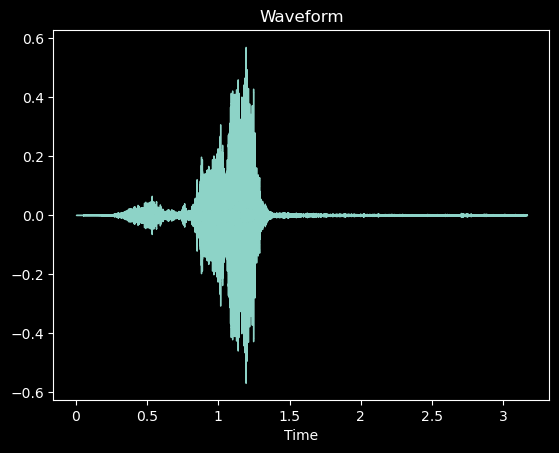

In [3]:
audio_path = "/Users/connorbarnsley/work/Personal/chinese_voice/cv-corpus-20.0-delta-2024-12-06/zh-CN/clips/common_voice_zh-CN_41297646.mp3"
y, sr = librosa.load(audio_path, sr=16000)

plt.figure()
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.show()


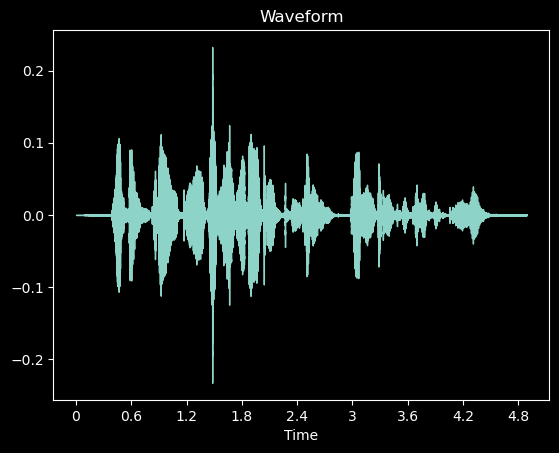

In [7]:
audio_path = "cv-corpus-20.0-delta-2024-12-06/zh-CN/clips/common_voice_zh-CN_41321020.mp3"
y, sr = librosa.load(audio_path, sr=16000)

plt.figure()
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.show()

# Dataset Reading

In [5]:
df = pd.read_csv('./large-corpus/other.tsv', sep='\t')
df.head(1)

/var/folders/mz/73jxv48x3tb6l6wc7_wvd7t00000gn/T/ipykernel_50844/2445831428.py:1: DtypeWarning: Columns (4,8,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./large-corpus/other.tsv', sep='\t')


,client_id,path,sentence_id,sentence,sentence_domain,up_votes,down_votes,age,gender,accents,variant,locale,segment
0,25bc975d06200b7b1c9135db090561cb0d9b28d172e51c...,common_voice_zh-CN_19703883.mp3,33bf426e7162122b062710c1aee44949efea3fef159bbb...,模式种采样自台湾龟山岛。,NaN,1,0,thirties,female_feminine,出生地：31 上海市,NaN,zh-CN,NaN


In [6]:
mdf = df[['path', 'sentence']]
mdf

,path,sentence
0,common_voice_zh-CN_19703883.mp3,模式种采样自台湾龟山岛。
1,common_voice_zh-CN_19706151.mp3,后者娶天之瓮主神。
2,common_voice_zh-CN_19961025.mp3,贝尔卢。
3,common_voice_zh-CN_20051292.mp3,日本与东帝汶的关系可追溯至第二次世界大战期间。
4,common_voice_zh-CN_20051309.mp3,单县各乡镇设有卫生院或医院。
...,...,...
600242,common_voice_zh-CN_41891247.mp3,炫家军来也！
600243,common_voice_zh-CN_41891248.mp3,索伊贝尔斯多尔夫是德国巴伐利亚州的一个市镇。
600244,common_voice_zh-CN_41891249.mp3,情报侦察：乌克兰军队通过加强情报侦察工作，及时获得敌方无人机的动向和部署情况，从而能够提前采...
600245,common_voice_zh-CN_41907107.mp3,三


# Manually Labeling Some Tones

In [7]:
mdf = mdf[mdf['sentence'].str.len() == 1]

value_counts = mdf['sentence'].value_counts()

filtered_value_counts = value_counts[value_counts >= 16]

# Filter the original DataFrame to only include the rows where the 'sentence' column is in the filtered values
result = mdf[mdf['sentence'].isin(filtered_value_counts.index)]


In [8]:
result['sentence'].value_counts()

sentence
否    1262
一    1258
九    1258
二    1257
五    1252
六    1249
四    1247
七    1246
零    1244
八    1232
三    1214
是    1212
Name: count, dtype: int64

In [61]:
sentence_to_tone = {
  '一': 1, '八': 1, '六': 4, '三': 3, '七': 1, '五': 3,
  '四': 4, '是': 4, '九': 3, '零': 2, '二': 4, '否': 3
}

result.loc[:, 'tone'] = result['sentence'].map(sentence_to_tone)

/var/folders/mz/73jxv48x3tb6l6wc7_wvd7t00000gn/T/ipykernel_8396/298768944.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result.loc[:, 'tone'] = result['sentence'].map(sentence_to_tone)


In [4]:
result.loc[:, 'wav_path'] = result['path'].apply(lambda x: x.split('_')[-1][:-4] + ".wav")

In [6]:
result = result.reset_index(drop=True)
result.head(6)

,path,sentence,tone,wav_path
0,common_voice_zh-CN_31167946.mp3,三,3,31167946.wav
1,common_voice_zh-CN_31196810.mp3,三,3,31196810.wav
2,common_voice_zh-CN_32705211.mp3,二,4,32705211.wav
3,common_voice_zh-CN_32705242.mp3,二,4,32705242.wav
4,common_voice_zh-CN_32706533.mp3,否,3,32706533.wav
5,common_voice_zh-CN_32707291.mp3,一,1,32707291.wav


## Convert to WAV files

In [7]:
# for multiprocessing script:
result.to_csv("result.csv", index=False)

In [9]:
# single processing way, TODO run mp3towav.py if want to reconvert
# for path in result['path']:
#  audio = pydub.AudioSegment.from_mp3('large-corpus/clips/' + path)
#  audio.export("./DANGER/large-wav/" + path.split('_')[-1][:-4] + ".wav", format="wav")

## Testing Extracting Features & Vis

In [27]:
y, sr = librosa.load('./test/yes.wav', sr=None)

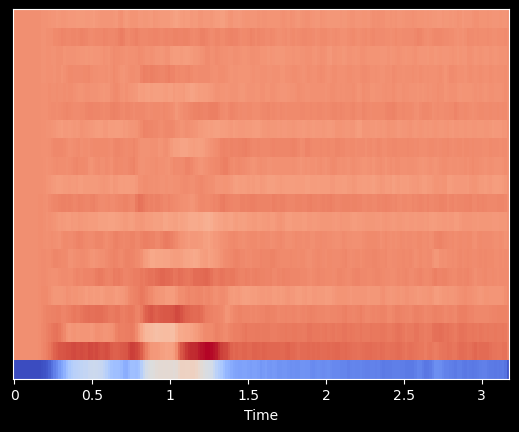

In [28]:
mfcc = librosa.feature.mfcc(y=y, sr=sr)
librosa.display.specshow(mfcc, sr=sr, x_axis='time')


In [29]:
print(np.min(mfcc), np.max(mfcc))
print(np.mean(mfcc), np.std(mfcc))

-611.4708 175.72095
-18.594261 102.39927


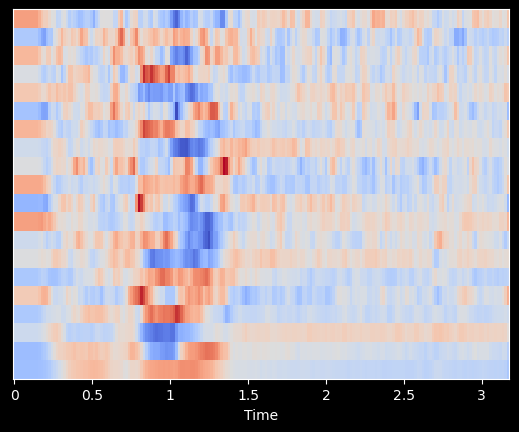

In [30]:
scaler = StandardScaler(with_mean=True, with_std=True)
mfcc_scaled = scaler.fit_transform(mfcc.T).T
librosa.display.specshow(mfcc_scaled, sr=sr, x_axis='time')

In [31]:
print(np.min(mfcc_scaled), np.max(mfcc_scaled))
print(np.mean(mfcc_scaled), np.std(mfcc_scaled))

-3.7818353 3.9447846
2.6357834e-09 1.0


In [23]:
print('pre: ', mfcc.shape)
print('scaled: ', mfcc_scaled.shape)

pre:  (20, 199)
scaled:  (20, 199)


In [33]:
# Convert MFCCs to tensor
mfcc_tensor = torch.tensor(mfcc_scaled).unsqueeze(0)

# time masked
time_masking = torchaudio.transforms.TimeMasking(time_mask_param=80)
time_masked = time_masking(mfcc_tensor)

# freq masked
freq_masking = torchaudio.transforms.FrequencyMasking(freq_mask_param=5)
freq_masked = freq_masking(time_masked)

# Remove batch dimension and convert back to numpy
masked_mfccs = freq_masked.squeeze(0).numpy()

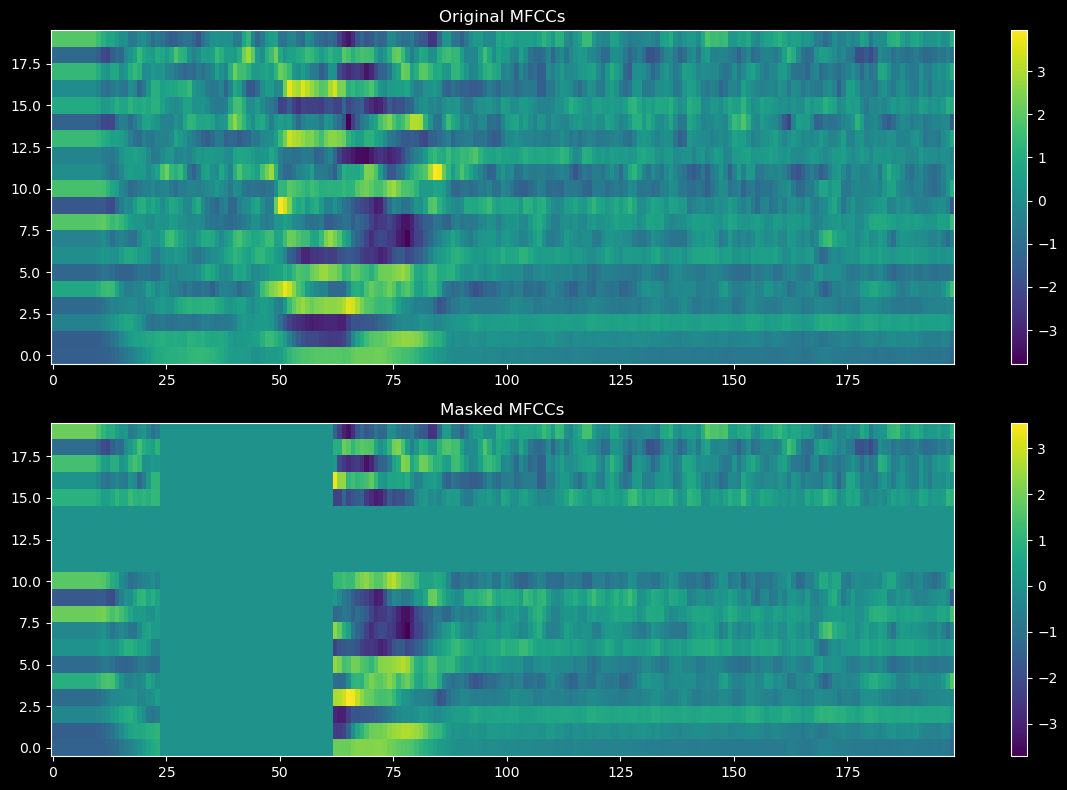

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.title("Original MFCCs")
plt.imshow(mfcc_scaled, aspect='auto', origin='lower')
plt.colorbar()

plt.subplot(2, 1, 2)
plt.title("Masked MFCCs")
plt.imshow(masked_mfccs, aspect='auto', origin='lower')
plt.colorbar()

plt.tight_layout()
plt.show()


In [23]:
y, sr = librosa.load('./test/yes.wav', sr=None)

Mel Spectograms are an intermediate step of the MFCC. the MFCC applies a discrete cosine transform (DCT) to compress the information - typically into 13-20 coefficients.

It is compressing so it does lose some information. can be better for more general audio tasks and simpler models being used. using the regular Mel Spectogram has more information and can be better for some more deep learning tasks, music related tasks or if you want to visualize the content in a more interpretable manner.

Mel spectogram code:
```
samples, sample_rate = librosa.load(AUDIO_FILE, sr=None)
sgram = librosa.stft(samples)
sgram_mag, _ = librosa.magphase(sgram)
mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sample_rate)
librosa.display.specshow(mel_scale_sgram)
```

In [24]:
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
zero_crossing_rate = librosa.feature.zero_crossing_rate(y)[0]
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)


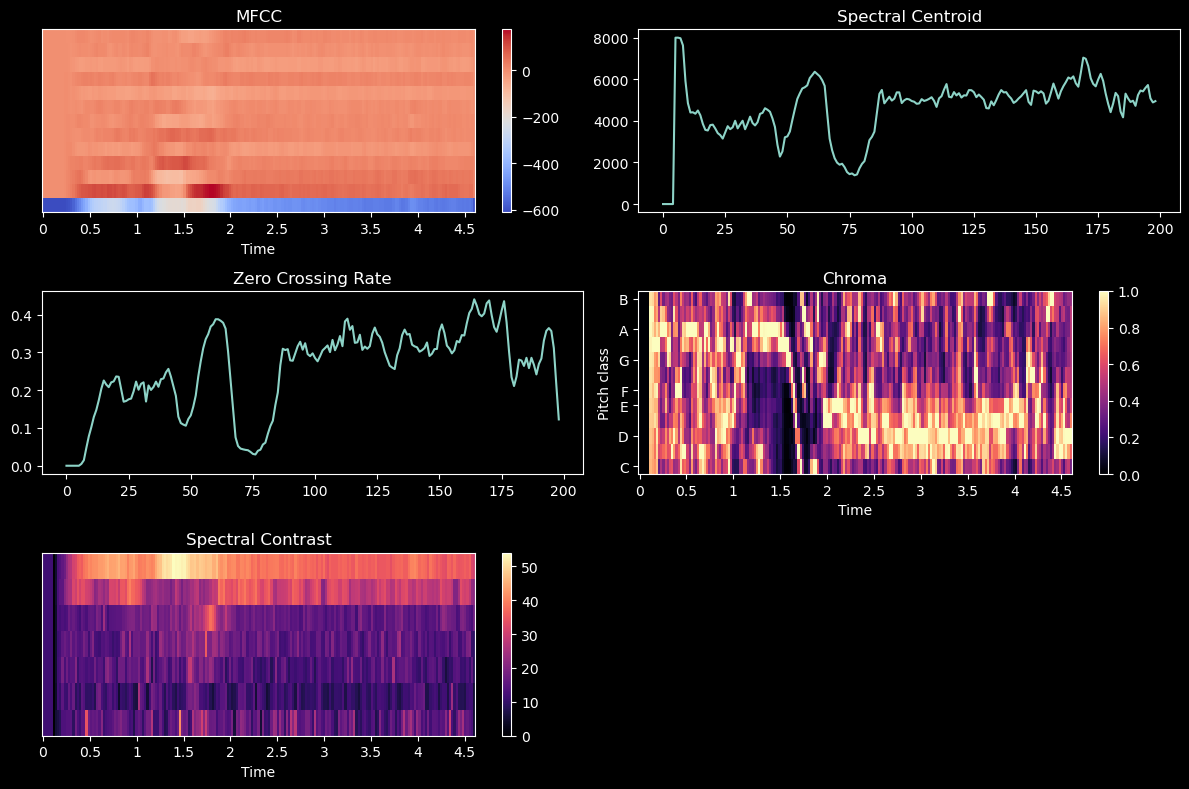

In [25]:
plt.figure(figsize=(12, 8))

plt.subplot(3, 2, 1)
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')

plt.subplot(3, 2, 2)
plt.plot(spectral_centroids)
plt.title('Spectral Centroid')

plt.subplot(3, 2, 3)
plt.plot(zero_crossing_rate)
plt.title('Zero Crossing Rate')

plt.subplot(3, 2, 4)
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chroma')

plt.subplot(3, 2, 5)
librosa.display.specshow(spectral_contrast, x_axis='time')
plt.colorbar()
plt.title('Spectral Contrast')

plt.tight_layout()
plt.show()


In [30]:
np.concatenate((mfccs, spectral_centroids.reshape(1, -1)), axis=0)


array([[-6.11470825e+02, -6.11470825e+02, -6.11470825e+02, ...,
        -5.27120911e+02, -5.38431702e+02, -5.87014038e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.93043213e+01,  4.86897278e+01,  2.35362701e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         3.84444313e+01,  3.51253738e+01,  2.20716743e+01],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.91402626e+00,  1.05771446e+00, -1.16770351e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.70999336e+00,  3.71721411e+00, -3.91070127e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         5.08548038e+03,  4.88749337e+03,  4.94986527e+03]])

# Extracting Features & Labels

In [2]:
import pandas as pd

In [3]:
result = pd.read_csv('./result.csv')

In [4]:
result.head()

,path,sentence,wav_path,tone,word_label
0,common_voice_zh-CN_31167946.mp3,三,31167946.wav,3,0
1,common_voice_zh-CN_31196810.mp3,三,31196810.wav,3,0
2,common_voice_zh-CN_32705211.mp3,二,32705211.wav,4,1
3,common_voice_zh-CN_32705242.mp3,二,32705242.wav,4,1
4,common_voice_zh-CN_32706533.mp3,否,32706533.wav,3,2


In [18]:
word_labels = { word: i for i, word in enumerate(list(result['sentence'].unique())) }
result.loc[:, 'word_label'] = result['sentence'].map(word_labels)

In [20]:
result.head()

,path,sentence,wav_path,tone,word_label
0,common_voice_zh-CN_31167946.mp3,三,31167946.wav,3,0
1,common_voice_zh-CN_31196810.mp3,三,31196810.wav,3,0
2,common_voice_zh-CN_32705211.mp3,二,32705211.wav,4,1
3,common_voice_zh-CN_32705242.mp3,二,32705242.wav,4,1
4,common_voice_zh-CN_32706533.mp3,否,32706533.wav,3,2


In [29]:
X = result['wav_path']
y_tone = result['tone'] 
y_word = result['word_label']

In [27]:
from sklearn.model_selection import train_test_split

In [35]:
one = list(zip(y_tone, y_word))

In [39]:
two = [y_tone, y_word]

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, list(zip(y_tone, y_word)), train_size=0.7, shuffle=True, random_state=RANDOM_SEED)

In [45]:
tone, word = zip(*y_train)

In [47]:
for labels in zip(*y_train):
  print(labels[0])

4
7


## Get good frame count to ensure np sizes align

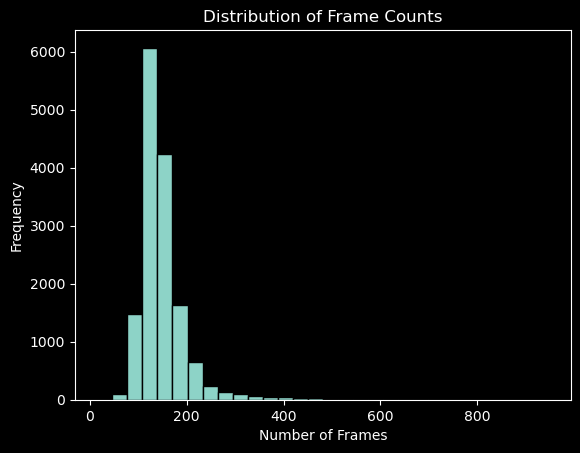

Max frames: 946
Mean frames: 151.32643493402986
Median frames: 138.0
95% percentile frames: 237


In [12]:
frame_counts = []

for index, row in result.iterrows():
    wav_file = row['wav_path']
    y, sr = librosa.load('./DANGER/large-wav/' + wav_file, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    frame_counts.append(mfccs.shape[1])

plt.hist(frame_counts, bins=30, edgecolor='black')
plt.title('Distribution of Frame Counts')
plt.xlabel('Number of Frames')
plt.ylabel('Frequency')
plt.show()

print(f"Max frames: {max(frame_counts)}")
print(f"Mean frames: {np.mean(frame_counts)}")
print(f"Median frames: {np.median(frame_counts)}")
print(f"95% percentile frames: {int(np.percentile(frame_counts, 95))}")


## this is now handled in `feature-extraction.py`

In [ ]:
all_features = []
all_labels = []

max_frames = int(np.percentile(frame_counts, 95))

for index, row in result.iterrows():
  wav_file = row['wav_path']
  tone = row['tone']
  y, sr = librosa.load('./DANGER/large-wav' + wav_file, sr=None)

  mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
  spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
  
  # ensure consistent shape
  if mfccs.shape[1] > max_frames:
    mfccs = mfccs[:, :max_frames]
    spectral_centroids = spectral_centroids[:max_frames]
  else:
    pad_width = max_frames - mfccs.shape[1]
    mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)), mode='constant')
    spectral_centroids = np.pad(spectral_centroids, (0, pad_width), mode='constant')
  
  # maybe could do some PCA decomp here
  combined_features = np.concatenate((mfccs, spectral_centroids.reshape(1, -1)), axis=0)
  
  all_features.append(combined_features)
  all_labels.append(tone) # could also just do all_labels = result['tone']

In [51]:
X = np.array(all_features)
y = np.array(all_labels)

np.save('features.npy', X)
np.save('labels.npy', y)

In [42]:
result['tone'].value_counts()

tone
4    216
3    215
1    177
2     53
Name: count, dtype: int64

# Build the Model

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from utils.constants import *
from models.BasicCNN import ChineseTonesCNN, ChineseTonesDataset

In [11]:
X_test = np.load(os.path.join(DATA_DIR / TEST_DIR, 'test_features.npy'))
y_test_tone = np.load(os.path.join(DATA_DIR / TEST_DIR, 'test_tone_labels.npy'))
y_test_word = np.load(os.path.join(DATA_DIR / TEST_DIR, 'test_word_labels.npy'))


# X_test = torch.FloatTensor(X_test)
# y_test_tone = torch.LongTensor(y_test_tone)
# y_test_word = torch.LongTensor(y_test_word)



In [12]:
X_test.shape

(100, 13, 237)

In [13]:
y_test_tone

array([3, 2, 2, 3, 0, 3, 2, 3, 2, 2, 3, 0, 2, 3, 0, 2, 2, 0, 0, 2, 2, 2,
       2, 3, 0, 1, 1, 0, 3, 3, 1, 3, 0, 0, 2, 0, 3, 0, 3, 3, 3, 3, 2, 3,
       0, 0, 3, 2, 2, 2, 2, 0, 2, 1, 1, 2, 3, 2, 3, 0, 2, 2, 2, 0, 3, 2,
       2, 0, 3, 0, 2, 2, 3, 0, 2, 2, 0, 3, 3, 2, 2, 3, 3, 2, 3, 1, 3, 3,
       3, 1, 3, 3, 3, 2, 2, 3, 2, 2, 3, 3])

In [14]:
y_test_word

array([10,  0,  6,  7,  3,  8,  9,  8,  2,  6,  8,  5,  2,  7, 11,  2,  2,
        3,  3,  6,  6,  9,  6,  7,  5,  4,  4,  5, 10,  8,  4,  7,  5,  3,
        6, 11,  1,  3,  1,  1, 10, 10,  9, 10, 11, 11,  8,  9,  2,  6,  9,
        3,  6,  4,  4,  0, 10,  2,  8, 11,  0,  2,  6,  3,  1,  0,  2,  3,
       10,  5,  0,  9,  1,  3,  6,  0,  5,  7,  1,  9,  0,  7,  1,  0,  7,
        4,  1,  1,  1,  4,  7,  8,  1,  6,  6,  7,  9,  2, 10,  7])

In [24]:
X = np.load(os.path.join(DATA_DIR, 'features.npy'))
y = np.load(os.path.join(DATA_DIR, 'labels.npy'))

X = torch.FloatTensor(X)
y = torch.LongTensor(y)

y = y - 1 # going to remove this soon when rerun the feature extraction

In [10]:
X.shape

torch.Size([14931, 13, 237])

In [11]:
y.shape

torch.Size([14931])

In [12]:
num_classes = len(torch.unique(y))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

train_dataset = ChineseTonesDataset(X_train, y_train)
test_dataset = ChineseTonesDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [14]:
model = ChineseTonesCNN(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
epochs = 10
for epoch in range(epochs):
  model.train()
  running_loss = 0.0
  for features_batch, labels_batch in train_dataloader:
    optimizer.zero_grad()
    outputs = model(features_batch)
    loss = criterion(outputs, labels_batch)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_dataloader)}")
    

Epoch 1/10, Loss: 1.0984815018257235
Epoch 2/10, Loss: 0.8187204273104303
Epoch 3/10, Loss: 0.6808108099556844
Epoch 4/10, Loss: 0.5720707132546544
Epoch 5/10, Loss: 0.48664783647665555
Epoch 6/10, Loss: 0.41242465203690604
Epoch 7/10, Loss: 0.34321452362821736
Epoch 8/10, Loss: 0.28379144558301395
Epoch 9/10, Loss: 0.24663016624999337
Epoch 10/10, Loss: 0.2096048845747195


In [16]:
model.eval()

correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
  for features_batch, labels_batch in test_dataloader:
    outputs = model(features_batch)
    _, predicted = torch.max(outputs, 1)
    total += labels_batch.size(0)
    correct += (predicted == labels_batch).sum().item()

    all_preds.extend(predicted.cpu().numpy())
    all_labels.extend(labels_batch.cpu().numpy())

accuracy = correct / total
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 75.96%


In [17]:

# Print a detailed classification report
print(classification_report(all_labels, all_preds))

# Print the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", conf_matrix)


              precision    recall  f1-score   support

           0       0.78      0.71      0.74      1136
           1       0.58      0.58      0.58       348
           2       0.79      0.83      0.81      1493
           3       0.76      0.76      0.76      1503

    accuracy                           0.76      4480
   macro avg       0.73      0.72      0.72      4480
weighted avg       0.76      0.76      0.76      4480

Confusion Matrix:
 [[ 805   79  118  134]
 [  54  203   31   60]
 [  59   20 1246  168]
 [ 113   50  191 1149]]


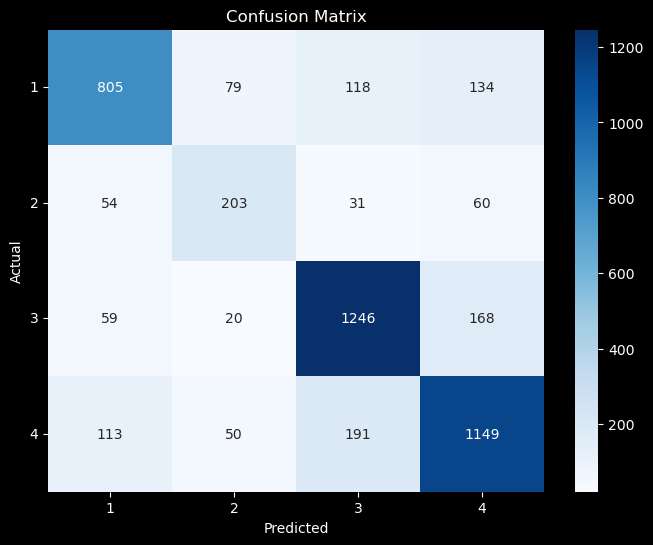

In [23]:
tones = [num + 1 for num in range(num_classes)]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=tones, yticklabels=tones)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.yticks(rotation=0)
plt.title('Confusion Matrix')
plt.show()


In [51]:
import torch

In [60]:
y_train_tone = torch.LongTensor([1, 0, 2, 3, 0, 0, 0, 0, 1, 2])
y_train_word = torch.LongTensor([1, 10, 4, 5, 7, 9, 3, 4, 8, 2])

In [53]:
X_train = torch.randint(10, 30, y_train.shape)


In [54]:
augment_rate = 1.2 # 20% of biggest class is augmented
unique_classes, class_counts = torch.unique(y_train, return_counts=True)
target_prop_dist = 1 / len(unique_classes) # is just .25 here
target = class_counts.max() * augment_rate

In [55]:
augments_needed = {clss.item(): max(0, int(target - count)) for clss, count in zip(unique_classes, class_counts)}

In [56]:
augments_needed

{0: 1, 1: 4, 2: 4, 3: 5}

In [57]:
from random import random, shuffle
from sklearn.utils import resample

In [49]:
from typing import List, Dict, Tuple

In [72]:
y_train = zip(y_train_tone, y_train_word)

y_tones, y_words = zip(*y_train)
y_words

(tensor(1),
 tensor(10),
 tensor(4),
 tensor(5),
 tensor(7),
 tensor(9),
 tensor(3),
 tensor(4),
 tensor(8),
 tensor(2))

In [82]:
y_tones = [y.item() if hasattr(y, 'item') else y for y in y_tones]
y_words = [y.item() if hasattr(y, 'item') else y for y in y_words]
X_train = [x.item() if hasattr(x, 'item') else x for x in X_train] 
y_words

[1, 10, 4, 5, 7, 9, 3, 4, 8, 2]

tensor([18, 25, 21, 14, 13, 28, 21, 26, 14, 13])

In [83]:
grouped_examples = {clss: [] for clss in augments_needed.keys()}
for x, y, z in zip(X_train, y_tones, y_words):
  grouped_examples[y].append((x, z))
  
grouped_examples

{0: [(25, 10), (13, 7), (28, 9), (21, 3), (26, 4)],
 1: [(18, 1), (14, 8)],
 2: [(21, 4), (13, 2)],
 3: [(14, 5)]}

In [86]:
X_train_new = []
y_tones_new = []
y_words_new = []
will_augment = []

# resampling each class, adding og & resampled to new X & new y & marking resampled ones for augmentation
for clss, n_samples in augments_needed.items():
  original_samples = grouped_examples[clss]
  augment_samples = resample(original_samples, replace=True, n_samples=n_samples, random_state=RANDOM_SEED)

  X_train_new.extend([x for x, _ in original_samples] + [x for x, _ in augment_samples])
  y_tones_new.extend([clss] * (len(original_samples) + len(augment_samples)))
  y_words_new.extend([y_word for _, y_word in original_samples] + [y_word for _, y_word in augment_samples])
  will_augment.extend([False] * len(original_samples) + [True] * len(augment_samples))

# shuffle to avoid any issues training later - sorted data iffy
combined_data = list(zip(X_train_new, y_tones_new, y_words_new, will_augment))
shuffle(combined_data)
  

In [87]:
combined_data

[(18, 1, 1, True),
 (13, 0, 7, False),
 (28, 0, 9, False),
 (13, 2, 2, True),
 (25, 0, 10, False),
 (18, 1, 1, True),
 (14, 3, 5, True),
 (21, 2, 4, False),
 (14, 3, 5, True),
 (14, 3, 5, True),
 (14, 3, 5, True),
 (14, 1, 8, False),
 (14, 3, 5, True),
 (21, 2, 4, True),
 (14, 1, 8, True),
 (21, 2, 4, True),
 (18, 1, 1, False),
 (21, 0, 3, False),
 (18, 1, 1, True),
 (13, 2, 2, False),
 (26, 0, 4, False),
 (21, 0, 3, True),
 (21, 2, 4, True),
 (14, 3, 5, False)]

In [67]:
a, b, c = assign_augmentations(list(X_train), zip(list(y_train_tone), list(y_train_word)), augments_needed)

KeyError: tensor(1)

In [45]:
torch.unique(torch.LongTensor(b), return_counts=True)

(tensor([0, 1, 2, 3]), tensor([6, 6, 6, 6]))

In [14]:
grouped_examples = {clss: [] for clss in augments_needed.keys()}
grouped_examples

{0: [], 1: [], 2: [], 3: []}

In [15]:
for x, y in zip(X_train, y_train):
  grouped_examples[y.item()].append(x)
grouped_examples

{0: [tensor(14), tensor(10), tensor(13), tensor(21), tensor(24)],
 1: [tensor(28), tensor(28)],
 2: [tensor(22), tensor(11)],
 3: [tensor(21)]}

In [19]:
from random import random
from random import sample
num_augs_per_sample = 2

In [20]:
augmentation_assignments = []
for clss, needed in augments_needed.items():
  if needed > 0:
    samples_needed = -(-needed // num_augs_per_sample)
    sampled_indices = sample(range(len(grouped_examples[clss])), min(samples_needed, len(grouped_examples[clss])))
    # Assign augmentation counts to sampled examples
    for idx in sampled_indices:
      augmentation_assignments.append((grouped_examples[clss][idx], clss, num_augs_per_sample))


In [21]:
augmentation_assignments

[(tensor(13), 0, 2),
 (tensor(28), 1, 2),
 (tensor(28), 1, 2),
 (tensor(11), 2, 2),
 (tensor(22), 2, 2),
 (tensor(21), 3, 2)]

In [3]:
import pandas as pd
from pypinyin import lazy_pinyin, Style
from pypinyin.contrib.tone_convert import to_initials, to_finals
import re
from sklearn.preprocessing import OneHotEncoder



In [30]:
dfLabels = pd.read_csv(RESULTS_PATH)
dfLabels

,path,sentence,wav_path,initial,final,tone
0,common_voice_zh-CN_31167946.mp3,三,31167946.wav,s,an,1
1,common_voice_zh-CN_31196810.mp3,三,31196810.wav,s,an,1
2,common_voice_zh-CN_32705211.mp3,二,32705211.wav,EMPTY,er,4
3,common_voice_zh-CN_32705242.mp3,二,32705242.wav,EMPTY,er,4
4,common_voice_zh-CN_32706533.mp3,否,32706533.wav,f,ou,3
...,...,...,...,...,...,...
14926,common_voice_zh-CN_41882588.mp3,八,41882588.wav,b,a,1
14927,common_voice_zh-CN_41882589.mp3,六,41882589.wav,l,iu,4
14928,common_voice_zh-CN_41882590.mp3,一,41882590.wav,y,i,1
14929,common_voice_zh-CN_41882591.mp3,五,41882591.wav,w,u,3


In [31]:
def breakdown_pinyin(phrase):
  clean_phrase = re.sub(r'[^\w]', '', phrase)
  init = lazy_pinyin(clean_phrase, style=Style.INITIALS, strict=False)
  final = lazy_pinyin(clean_phrase, style=Style.FINALS, strict=False)
  tone = [ word[-1] for word in lazy_pinyin(clean_phrase, style=Style.FINALS_TONE3, strict=False, neutral_tone_with_five=True, tone_sandhi=True)]
  return (init, final, tone)

In [32]:
text = "嗯你好吗，怎么样啊，饿吗"
breakdown_pinyin(text)

(['', 'n', 'h', 'm', 'z', 'm', 'y', '', '', 'm'],
 ['n', 'i', 'ao', 'a', 'en', 'e', 'ang', 'a', 'e', 'a'],
 ['2', '2', '3', '5', '3', '5', '4', '5', '4', '5'])

In [33]:
dfLabels

,path,sentence,wav_path,initial,final,tone
0,common_voice_zh-CN_31167946.mp3,三,31167946.wav,s,an,1
1,common_voice_zh-CN_31196810.mp3,三,31196810.wav,s,an,1
2,common_voice_zh-CN_32705211.mp3,二,32705211.wav,EMPTY,er,4
3,common_voice_zh-CN_32705242.mp3,二,32705242.wav,EMPTY,er,4
4,common_voice_zh-CN_32706533.mp3,否,32706533.wav,f,ou,3
...,...,...,...,...,...,...
14926,common_voice_zh-CN_41882588.mp3,八,41882588.wav,b,a,1
14927,common_voice_zh-CN_41882589.mp3,六,41882589.wav,l,iu,4
14928,common_voice_zh-CN_41882590.mp3,一,41882590.wav,y,i,1
14929,common_voice_zh-CN_41882591.mp3,五,41882591.wav,w,u,3


In [26]:
labels = dfLabels['sentence'].apply(lambda x: pd.Series(breakdown_pinyin(x))).rename(columns={0: 'initial', 1: 'final', 2: 'tone'})

In [27]:
labels

,initial,final,tone
0,[s],[an],[1]
1,[s],[an],[1]
2,[],[er],[4]
3,[],[er],[4]
4,[f],[ou],[3]
...,...,...,...
14926,[b],[a],[1]
14927,[l],[iu],[4]
14928,[y],[i],[1]
14929,[w],[u],[3]


In [36]:
dfLabels

,path,sentence,wav_path,initial,final,tone
0,common_voice_zh-CN_31167946.mp3,三,31167946.wav,s,an,1
1,common_voice_zh-CN_31196810.mp3,三,31196810.wav,s,an,1
2,common_voice_zh-CN_32705211.mp3,二,32705211.wav,EMPTY,er,4
3,common_voice_zh-CN_32705242.mp3,二,32705242.wav,EMPTY,er,4
4,common_voice_zh-CN_32706533.mp3,否,32706533.wav,f,ou,3
...,...,...,...,...,...,...
14926,common_voice_zh-CN_41882588.mp3,八,41882588.wav,b,a,1
14927,common_voice_zh-CN_41882589.mp3,六,41882589.wav,l,iu,4
14928,common_voice_zh-CN_41882590.mp3,一,41882590.wav,y,i,1
14929,common_voice_zh-CN_41882591.mp3,五,41882591.wav,w,u,3


In [115]:
def one_hot_labels(initials, finals, tones):
  # labels = []
  # for i in range(len(initials)):
    # labels.append(np.array([initials[i] if initials[i] != '' else 'EMPTY', finals[i], tones[i]]).T)
  # return labels
  return [initials[0] if initials[0] != '' else 'EMPTY', finals[0], tones[0]]

In [38]:
one_hot_labels(dfLabels.loc[0, 'initial'], dfLabels.loc[0, 'final'], dfLabels.loc[0, 'tone'])

['s', 'an', 1]

In [39]:
dfLabels.apply(lambda row: one_hot_labels(row['initial'], row['final'], row['tone']), axis=1)

0            [s, an, 1]
1            [s, an, 1]
2        [EMPTY, er, 4]
3        [EMPTY, er, 4]
4            [f, ou, 3]
              ...      
14926         [b, a, 1]
14927        [l, iu, 4]
14928         [y, i, 1]
14929         [w, u, 3]
14930        [s, an, 1]
Length: 14931, dtype: object

In [40]:
stacked_labels = dfLabels.apply(lambda row: one_hot_labels(row['initial'], row['final'], row['tone']), axis=1).tolist()

In [41]:
stacked_labels[0:10]

[['s', 'an', 1],
 ['s', 'an', 1],
 ['EMPTY', 'er', 4],
 ['EMPTY', 'er', 4],
 ['f', 'ou', 3],
 ['y', 'i', 1],
 ['f', 'ou', 3],
 ['l', 'ing', 2],
 ['y', 'i', 1],
 ['l', 'ing', 2]]

In [43]:
encoder = OneHotEncoder(sparse_output=False)


In [121]:
stacked_labels[0]

['s', 'an', '1']

In [44]:
encoder.fit(stacked_labels)
one_hot_encoded = encoder.transform(stacked_labels)
print(one_hot_encoded)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [139]:
one_hot_encoded.shape

(14931, 22)

In [147]:
encoder.inverse_transform(one_hot_encoded)

array([['s', 'an', '1'],
       ['s', 'an', '1'],
       ['EMPTY', 'er', '4'],
       ...,
       ['y', 'i', '1'],
       ['w', 'u', '3'],
       ['s', 'an', '1']], dtype=object)

In [143]:
print("inits:", encoder.categories_[0])
print("finals:",encoder.categories_[1])
print("tones:",encoder.categories_[2])


inits: ['EMPTY' 'b' 'f' 'j' 'l' 'q' 's' 'sh' 'w' 'y']
finals: ['a' 'an' 'er' 'i' 'ing' 'iu' 'ou' 'u']
tones: ['1' '2' '3' '4']


In [144]:
feature_names = encoder.get_feature_names_out()
print(feature_names)


['x0_EMPTY' 'x0_b' 'x0_f' 'x0_j' 'x0_l' 'x0_q' 'x0_s' 'x0_sh' 'x0_w'
 'x0_y' 'x1_a' 'x1_an' 'x1_er' 'x1_i' 'x1_ing' 'x1_iu' 'x1_ou' 'x1_u'
 'x2_1' 'x2_2' 'x2_3' 'x2_4']


In [27]:
encoder.fit(labels)

OneHotEncoder(sparse_output=False)

In [28]:
one_hot_encoded = encoder.transform(labels)
print(one_hot_encoded)


[[1. 0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 1. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 1. 1. 0. 0.]]


In [129]:
newDF['initial'].value_counts()

initial
[l]     2493
[s]     2461
[f]     1262
[y]     1258
[j]     1258
[]      1257
[w]     1252
[q]     1246
[b]     1232
[sh]    1212
Name: count, dtype: int64

In [130]:
newDF['final'].value_counts()

final
[i]      4963
[iu]     2507
[ou]     1262
[er]     1257
[u]      1252
[ing]    1244
[a]      1232
[an]     1214
Name: count, dtype: int64

In [131]:
newDF['tone'].value_counts()

tone
[4]    4965
[1]    4950
[3]    3772
[2]    1244
Name: count, dtype: int64

In [1]:
from sklearn.preprocessing import OneHotEncoder

# BREAKDOWN ON ENTIRE SENTENCES

In [133]:
df = pd.read_csv('./large-corpus/other.tsv', sep='\t')
df.head(5)

/var/folders/mz/73jxv48x3tb6l6wc7_wvd7t00000gn/T/ipykernel_27653/4203018780.py:1: DtypeWarning: Columns (4,8,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./large-corpus/other.tsv', sep='\t')


,client_id,path,sentence_id,sentence,sentence_domain,up_votes,down_votes,age,gender,accents,variant,locale,segment
0,25bc975d06200b7b1c9135db090561cb0d9b28d172e51c...,common_voice_zh-CN_19703883.mp3,33bf426e7162122b062710c1aee44949efea3fef159bbb...,模式种采样自台湾龟山岛。,NaN,1,0,thirties,female_feminine,出生地：31 上海市,NaN,zh-CN,NaN
1,25bc975d06200b7b1c9135db090561cb0d9b28d172e51c...,common_voice_zh-CN_19706151.mp3,35366aede353c3bd5974533a49486e7ff97ff8b4824da0...,后者娶天之瓮主神。,NaN,1,0,thirties,female_feminine,出生地：31 上海市,NaN,zh-CN,NaN
2,faa0ecc626e80638016d6295b5018372b8567f5f3177f6...,common_voice_zh-CN_19961025.mp3,3c0175be56f9bd82f1b81c878eb20316a3b1479cb13f24...,贝尔卢。,NaN,1,0,twenties,male_masculine,出生地：32 江苏省,NaN,zh-CN,NaN
3,61327f8ca2a6cdf961b07e3c9e294f9472c572cd457156...,common_voice_zh-CN_20051292.mp3,37697e2f42aa159f2c2e8669d9a2e065ab0287174d05ec...,日本与东帝汶的关系可追溯至第二次世界大战期间。,NaN,0,1,twenties,male_masculine,出生地：13 河北省,NaN,zh-CN,NaN
4,61327f8ca2a6cdf961b07e3c9e294f9472c572cd457156...,common_voice_zh-CN_20051309.mp3,3c9fd6b7d8c0181caea41df3c4a353d4ce6c4928170bc6...,单县各乡镇设有卫生院或医院。,NaN,0,0,twenties,male_masculine,出生地：13 河北省,NaN,zh-CN,NaN


In [145]:
df.shape

(600247, 13)

In [134]:
df['accents'].value_counts()

accents
出生地：11 北京市             3932
出生地：36 江西省             3627
出生地：44 广东省             2123
出生地：12 天津市             1637
出生地：23 黑龙江省            1363
                       ... 
出生地：36 江西省,南方人,有点口胡       4
出生地：43 湖南省,株洲普通话          4
出生地：马来西亚,中文高等教育水平         3
出生地：50 重庆市,快              2
出生地：21 辽宁省,基本上就普通话        1
Name: count, Length: 91, dtype: int64

In [150]:
len(df[df['down_votes'] == 0])

584496

In [153]:
myDF = df[['sentence_id', 'path', 'sentence']]

In [154]:
myDF['sentence'].apply(lambda x: pd.Series(breakdown_pinyin(x))).rename(columns={0: 'initial', 1: 'final', 2: 'tone'})

,initial,final,tone
0,"[m, sh, zh, c, y, z, t, w, g, sh, d]","[o, i, ong, ai, ang, i, ai, an, ui, an, ao]","[2, 4, 3, 3, 4, 4, 2, 1, 1, 1, 3]"
1,"[h, zh, q, t, zh, w, zh, sh]","[ou, e, u, ian, i, eng, u, en]","[4, 3, 3, 1, 1, 4, 3, 2]"
2,"[b, , l]","[ei, er, u]","[4, 3, 2]"
3,"[r, b, y, d, d, w, d, g, x, k, zh, s, zh, d, ,...","[i, en, u, ong, i, en, e, uan, i, e, ui, u, i,...","[4, 3, 3, 1, 4, 4, 5, 1, 4, 3, 1, 4, 4, 4, 4, ..."
4,"[d, x, g, x, zh, sh, y, w, sh, y, h, y, y]","[an, ian, e, iang, en, e, ou, ei, eng, uan, uo...","[1, 4, 4, 1, 4, 4, 3, 4, 1, 4, 4, 1, 4]"
...,...,...,...
600242,"[x, j, j, l, y]","[uan, ia, un, ai, e]","[4, 1, 1, 2, 3]"
600243,"[s, y, b, , s, d, , f, sh, d, g, b, f, l, y, z...","[uo, i, ei, er, i, uo, er, u, i, e, uo, a, a, ...","[3, 1, 4, 3, 1, 1, 3, 1, 4, 2, 2, 1, 2, 4, 4, ..."
600244,"[q, b, zh, ch, w, k, l, j, d, t, g, j, q, q, b...","[ing, ao, en, a, u, e, an, un, ui, ong, uo, ia...","[2, 4, 1, 2, 1, 4, 2, 1, 4, 1, 4, 1, 2, 2, 4, ..."
600245,[s],[an],[1]


# TESTING

In [45]:
result = pd.read_csv(RESULTS_PATH)
result.head()

,path,sentence,wav_path,initial,final,tone
0,common_voice_zh-CN_31167946.mp3,三,31167946.wav,s,an,1
1,common_voice_zh-CN_31196810.mp3,三,31196810.wav,s,an,1
2,common_voice_zh-CN_32705211.mp3,二,32705211.wav,EMPTY,er,4
3,common_voice_zh-CN_32705242.mp3,二,32705242.wav,EMPTY,er,4
4,common_voice_zh-CN_32706533.mp3,否,32706533.wav,f,ou,3


In [14]:
result.apply(lambda row: [row['initial'], row['final'], row['tone']], axis=1).tolist()

[['s', 'an', 1],
 ['s', 'an', 1],
 ['EMPTY', 'er', 4],
 ['EMPTY', 'er', 4],
 ['f', 'ou', 3],
 ['y', 'i', 1],
 ['f', 'ou', 3],
 ['l', 'ing', 2],
 ['y', 'i', 1],
 ['l', 'ing', 2],
 ['q', 'i', 1],
 ['w', 'u', 3],
 ['q', 'i', 1],
 ['l', 'iu', 4],
 ['l', 'iu', 4],
 ['s', 'i', 4],
 ['s', 'i', 4],
 ['j', 'iu', 3],
 ['sh', 'i', 4],
 ['sh', 'i', 4],
 ['j', 'iu', 3],
 ['s', 'an', 1],
 ['s', 'an', 1],
 ['b', 'a', 1],
 ['b', 'a', 1],
 ['f', 'ou', 3],
 ['f', 'ou', 3],
 ['f', 'ou', 3],
 ['f', 'ou', 3],
 ['f', 'ou', 3],
 ['f', 'ou', 3],
 ['f', 'ou', 3],
 ['f', 'ou', 3],
 ['f', 'ou', 3],
 ['f', 'ou', 3],
 ['f', 'ou', 3],
 ['l', 'ing', 2],
 ['f', 'ou', 3],
 ['f', 'ou', 3],
 ['l', 'ing', 2],
 ['f', 'ou', 3],
 ['l', 'ing', 2],
 ['l', 'ing', 2],
 ['f', 'ou', 3],
 ['f', 'ou', 3],
 ['w', 'u', 3],
 ['l', 'ing', 2],
 ['l', 'ing', 2],
 ['w', 'u', 3],
 ['f', 'ou', 3],
 ['f', 'ou', 3],
 ['l', 'ing', 2],
 ['w', 'u', 3],
 ['f', 'ou', 3],
 ['w', 'u', 3],
 ['l', 'ing', 2],
 ['w', 'u', 3],
 ['l', 'ing', 2],
 ['f', 'o

In [55]:
import joblib


In [56]:
def one_hot_labels(initials, finals, tones):
  # labels = []
  # for i in range(len(initials)):
    # labels.append(np.array([initials[i] if initials[i] != '' else 'EMPTY', finals[i], tones[i]]).T)
  # return labels
  return [initials[0], finals[0], tones]

def generate_labels(df):
  """generates the onehots & saves the encoding categories to decode at prediction time

  Args:
      df (): pd df w labels

  Returns:
      _type_: _description_
  """
  stacked_labels = df.apply(lambda row: one_hot_labels(row['initial'], row['final'], row['tone']), axis=1).tolist()
  encoder = OneHotEncoder(sparse_output=False)
  encoder.fit(stacked_labels)
  one_hot_encoded = encoder.transform(stacked_labels)
  
  joblib.dump(encoder, "one_hot_encoder.pkl")

  return one_hot_encoded


In [58]:
  X = result['wav_path']
  y = generate_labels(result)

In [61]:
X_train = torch.tensor(np.load(DATA_DIR / TEST_DATA_DIR / 'train_features.npy')).unsqueeze(1)
X_test = torch.tensor(np.load(DATA_DIR / TEST_DATA_DIR / 'test_features.npy')).unsqueeze(1)
y_train = torch.tensor(np.load(DATA_DIR / TEST_DATA_DIR / 'train_labels.npy'))
y_test = torch.tensor(np.load(DATA_DIR / TEST_DATA_DIR / 'test_labels.npy'))